<a href="https://colab.research.google.com/github/Gibbons-Lab/isb_course_2020/blob/master/micom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧫🦠 Modeling microbiota-wide metabolism with MICOM

This notebook will accompany the second session of the 2020 ISB Microbiome Course. The presentation slides can be [found here](https://gibbons-lab.github.io/isb_course_2020/micom). 

You can save your own local copy of this notebook by using `File > Save a copy in Drive`. You may be promted to cetify the notebook is safe. We promise that it is 🤞

**Disclaimer:**
The linear and quadratic programming problems MICOM has to solve are very large and very complicated. There are some very good commercial solvers that are very expensive (even though they are often free for academic use). To make this tutorial as accessible as possible we will use the Open Source solver [OSQP](https://osqp.org/). OSQP is amazing with quadratic programming problems (kudos!) but not as accurate for linear problems. Solvers usually only guarantee a solution within a certain numerical tolerance of the real solution. In order to make everything work with OSQP this tolerance has to be relaxed to about 10<sup>-3</sup>. This means that any result with an absolute value smaller than that might very well be zero so we should look at larger values only. Installing cost-free academic versions of commercial solvers like [IBM CPLEX](https://www.ibm.com/analytics/cplex-optimizer) or [Gurobi](https://www.gurobi.com/) would alow you to lower the tolerance to 10<sup>-6</sup>.



# 📝 Setup

MICOM installation is is usually pretty straight-forward and can be as easy as typing `pip install micom` into your Terminal. However, MICOM will require a solver for quadratic programming problems and all the best ones are commercial (boo) even though they often have free academic licenses 😌. We will use a brand new open source QP solver named OSQP, but this will require us to pull in development versions of certain packages.

But first let's start by downloading the materials again and switching to the folder.

In [ ]:
#!git clone https://github.com/gibbons-lab/isb_course_2020 materials
# %cd materials

## Basic Installation

Installing MICOM is straight-forward in Python. OSQP itself will be installed automatically along with it.

In [1]:
#!pip install -q micom

# print("Done! 🎉 ")

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
marsilea 0.4.6 requires matplotlib>=3.6, which is not installed.
marsilea 0.4.6 requires seaborn, which is not installed.
gget 0.29.0 requires matplotlib, which is not installed.
umap-learn 0.5.6 requires numba>=0.51.2, which is not installed.
lineax 0.0.6 requires jaxtyping>=0.2.20, which is not installed.
upsetplot 0.9.0 requires matplotlib>=2.0, which is not installed.
sparse 0.15.4 requires numba>=0.49, which is not installed.
matplotlib-venn 1.1.2 requires matplotlib, which is not installed.
magic-impute 3.0.0 requires matplotlib, which is not installed.
pertpy 0.9.4 requires anndata<0.10.9, which is not installed.
pertpy 0.9.4 requires decoupler, which is not installed.
pertpy 0.9.4 requires sc

## Enable QIIME 2 interactions

Finally we will need to install packages to read the "biom" format which is a file format QIIME 2 uses to save tables. This is only necessary if you want to read QIIME 2 FeatureTable artifacts.

In [2]:
#!pip install -q numpy Cython
#!pip install -q biom-format

# print("Done! 🎉 ")

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Done! 🎉 


Okay, all done. So let's get started 😁.

# 💻 MICOM

We will use the Python interface to MICOM since it plays nicely with Colaboratory. However, you could run the same steps within the QIIME 2 MICOM plugin ([q2-micom](https://library.qiime2.org/plugins/q2-micom/26/)). 

Here is an overview of all the steps and functions:
![micom overview](https://github.com/micom-dev/q2-micom/raw/706f583a060b91c12c0cec7acea2354fdd0dd320/docs/assets/overview.png).

MICOM starts from a combined abundance/taxonomy table, which MICOM abbreviates to a taxonomy table. To see how those tables look we can import MICOM and look at an example table:


In [2]:
# from micom.data import test_data

# test_data().head()

id        genus             species  reactions  \
0  Escherichia_coli_1  Escherichia  Escherichia coli 0         95   
1  Escherichia_coli_2  Escherichia  Escherichia coli 1         95   
2  Escherichia_coli_3  Escherichia  Escherichia coli 2         95   
3  Escherichia_coli_4  Escherichia  Escherichia coli 3         95   
0  Escherichia_coli_1  Escherichia  Escherichia coli 0         95   

   metabolites sample_id  abundance  
0           72  sample_1        214  
1           72  sample_1        855  
2           72  sample_1        799  
3           72  sample_1         41  
0           72  sample_2         38

The `file` column is not required when using a taxonomy database like we will do here. The `id` column specifies identifiers for the taxa and should be expressive and not include spaces or special characters. Each row needs to contain the the abundance of a single taxon in a single sample. 

Oh no, that's not what we have generated in the previous step. We only have separate QIIME 2 artifacts 😱 

No worries, we can deal with that.

## Importing data from QIIME 2

MICOM can read QIIME 2 artifacts. You don't even need to have QIIME 2 installed for that! But before we do so, let's resolve one issue. We discussed that MICOM summarizes genome-scale models into pangenome-scale models as a first step, but our data are on the ASV level...so how will we know what to summarize?

Basically, specific model database can be used to quickly summarize pangenome-scale models for use within MICOM. So, before we read our data we have to decide which model database to use. We will go with the [AGORA database](https://pubmed.ncbi.nlm.nih.gov/27893703/), which is a curated database of more than 800 bacterial strains that commonly live in the human gut. In particular, we will use a version of this database summarized on the genus rank which can be downloaded from [MICOM data repository](https://doi.org/10.5281/zenodo.3755182) which contains a whole lot of prebuilt databases.



In [4]:
#!wget -O agora103_genus.qza https://zenodo.org/record/3755182/files/agora103_genus.qza?download=1

--2025-06-24 10:12:00--  https://zenodo.org/record/3755182/files/agora103_genus.qza?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3755182/files/agora103_genus.qza [following]
--2025-06-24 10:12:00--  https://zenodo.org/records/3755182/files/agora103_genus.qza
Reusing existing connection to zenodo.org:443.
200 OKequest sent, awaiting response... 
Length: 21080080 (20M) [application/octet-stream]
Saving to: ‘agora103_genus.qza’

agora103_genus.qza  100%[===================>]  20.10M  5.97MB/s    in 3.5s    

2025-06-24 10:12:04 (5.75 MB/s) - ‘agora103_genus.qza’ saved [21080080/21080080]



Okay. We've got everything we need now. The data from the prior analysis can be found in the `treasure_chest` folder, so we can use those files.

In [1]:
from micom.taxonomy import qiime_to_micom

tax = qiime_to_micom(
    "/data/projects/2024/Effenberger-Diabetes/out/nf_core_ampliseq_vsearch/qiime2/input/table.qza",
    "/data/projects/2024/Effenberger-Diabetes/out/nf_core_ampliseq_vsearch/qiime2/input/taxonomy.qza",
    collapse_on="genus",
)

Notice the `collapse_on` argument. That will specify the rank on which to sumarize and can be a list of several ranks. When matching taxonomy you can either match by the particular rank of interest (for example, just comparing genus names here), or you could compare the entire taxonomy, which will require all taxonomic ranks prior to the target rank to match. For that you cloud specify `collapse_on=["kingdom", "phylum", "class", "order", "family", "genus"]`. 

Taxonomic names will often not match 100% between databases. For instance, the genus name "Prevotella" in one database may be "Prevotella_6" in another. The more ranks you use for matching the more likely are you to run into those issues. However, the more taxonomic ranks you use to match the more confident you can be that your observed taxon really is the same taxon as the one in the model database.

The resulting table will contain the same abundances but it will include more ranks if `collapse_on` is a list. All ranks present in the taxonomy will be used when matching to the database. The GreenGenes database is pretty old and many taxonomic names have been superceded by now. So we will stick with the "lax" option of only matching on genus ranks.

We can also look at the generated MICOM taxonomy.

In [2]:
tax

sample_id  abundance               genus                  id  relative
0     s20011_0001     2278.0         Akkermansia         Akkermansia  0.070077
1     s20011_0002        3.0         Akkermansia         Akkermansia  0.000114
2     s20011_0003     1745.0         Akkermansia         Akkermansia  0.062774
3     s20011_0004      105.0         Akkermansia         Akkermansia  0.009201
4     s20011_0005      111.0         Akkermansia         Akkermansia  0.003539
...           ...        ...                 ...                 ...       ...
4094  s20011_0047        3.0         Floricoccus         Floricoccus  0.000119
4095  s20011_0018        2.0          Isobaculum          Isobaculum  0.000048
4096  s20011_0024        2.0  Celerinatantimonas  Celerinatantimonas  0.000070
4097  s20011_0028        2.0        Murdochiella        Murdochiella  0.000096
4098  s20011_0040        1.0       Pluralibacter       Pluralibacter  0.000018

[4051 rows x 5 columns]

One helpful thing to do is to merge in our metadata, so we'll have it at hand for the following steps.

In [3]:
import pandas as pd

metadata = pd.read_table(
    "/data/scratch/kvalem/projects/2024/Effenberger-Diabetes/02-scripts/nf-core_ampliseq/metadata.tsv"
).rename(columns={"id": "sample_id"})

In [4]:
metadata

sample_id sample_information               condition nikotin     sex  \
0   s20011_0001                 K1               Kontrolle      no  female   
1   s20011_0002               PDM1  pankreopriver Diabetes     yes  female   
2   s20011_0003              PDM13  pankreopriver Diabetes      no    male   
3   s20011_0004                DM1  Diabetes mellitus Typ1      no  female   
4   s20011_0005               DM13  Diabetes mellitus Typ1      no  female   
5   s20011_0006                 K2               Kontrolle      no  female   
6   s20011_0007               PDM2  pankreopriver Diabetes      no    male   
7   s20011_0008              PDM14  pankreopriver Diabetes      no  female   
8   s20011_0009                DM2  Diabetes mellitus Typ1      no    male   
9   s20011_0010               DM14  Diabetes mellitus Typ1      no  female   
10  s20011_0011                 K3               Kontrolle      no    male   
11  s20011_0013              PDM15  pankreopriver Diabetes     yes  female   
12  s20011_0014                DM3  Diabetes mellitus Typ1     yes    male   
13  s20011_0015               DM15  Diabetes mellitus Typ1      no  female   
14  s20011_0016                 K4               Kontrolle      no    male   
15  s20011_0017               PDM4  pankreopriver Diabetes     yes    male   
16  s20011_0018              PDM16  pankreopriver Diabetes      no  female   
17  s20011_0019                DM4  Diabetes mellitus Typ1      no    male   
18  s20011_0020               DM16  Diabetes mellitus Typ1     yes    male   
19  s20011_0021                 K5               Kontrolle      no  female   
20  s20011_0022               PDM5  pankreopriver Diabetes      no  female   
21  s20011_0023              PDM17  pankreopriver Diabetes      no    male   
22  s20011_0024                DM5  Diabetes mellitus Typ1     yes  female   
23  s20011_0025               DM17  Diabetes mellitus Typ1      no  female   
24  s20011_0026                 K6               Kontrolle      no  female   
25  s20011_0027               PDM6  pankreopriver Diabetes     yes    male   
26  s20011_0028              PDM18  pankreopriver Diabetes     yes  female   
27  s20011_0029                DM6  Diabetes mellitus Typ1      no  female   
28  s20011_0030               DM18  Diabetes mellitus Typ1      no  female   
29  s20011_0031                 K7               Kontrolle      no    male   
30  s20011_0032               PDM7  pankreopriver Diabetes     yes    male   
31  s20011_0033                DM7  Diabetes mellitus Typ1     yes    male   
32  s20011_0034               DM19  Diabetes mellitus Typ1      no    male   
33  s20011_0035                 K8               Kontrolle      no    male   
34  s20011_0036               PDM8  pankreopriver Diabetes     yes    male   
35  s20011_0037                DM8  Diabetes mellitus Typ1      no    male   
36  s20011_0038               DM20  Diabetes mellitus Typ1      no  female   
37  s20011_0039                 K9               Kontrolle      no  female   
38  s20011_0040               PDM9  pankreopriver Diabetes     yes    male   
39  s20011_0041                DM9  Diabetes mellitus Typ1      no    male   
40  s20011_0042               DM21  Diabetes mellitus Typ1     yes  female   
41  s20011_0043                K10               Kontrolle      no    male   
42  s20011_0044              PDM10  pankreopriver Diabetes     yes    male   
43  s20011_0045               DM10  Diabetes mellitus Typ1      no    male   
44  s20011_0046              PDM11  pankreopriver Diabetes     yes    male   
45  s20011_0047               DM11  Diabetes mellitus Typ1      no    male   
46  s20011_0048              PDM12  pankreopriver Diabetes      no    male   
47  s20011_0049               DM12  Diabetes mellitus Typ1      no    male   

   age_group   AH  
0     more50   no  
1     more50  yes  
2     more50  yes  
3     more50  yes  
4     less50   no  
5     more50   no  
6     more50  yes  
7     more50  yes  
8  

In [5]:
tax = pd.merge(tax, metadata, on="sample_id")
tax

sample_id  abundance               genus                  id  \
0     s20011_0001     2278.0         Akkermansia         Akkermansia   
1     s20011_0002        3.0         Akkermansia         Akkermansia   
2     s20011_0003     1745.0         Akkermansia         Akkermansia   
3     s20011_0004      105.0         Akkermansia         Akkermansia   
4     s20011_0005      111.0         Akkermansia         Akkermansia   
...           ...        ...                 ...                 ...   
4046  s20011_0047        3.0         Floricoccus         Floricoccus   
4047  s20011_0018        2.0          Isobaculum          Isobaculum   
4048  s20011_0024        2.0  Celerinatantimonas  Celerinatantimonas   
4049  s20011_0028        2.0        Murdochiella        Murdochiella   
4050  s20011_0040        1.0       Pluralibacter       Pluralibacter   

      relative sample_information               condition nikotin     sex  \
0     0.070077                 K1               Kontrolle      no  female   
1     0.000114               PDM1  pankreopriver Diabetes     yes  female   
2     0.062774              PDM13  pankreopriver Diabetes      no    male   
3     0.009201                DM1  Diabetes mellitus Typ1      no  female   
4     0.003539               DM13  Diabetes mellitus Typ1      no  female   
...        ...                ...                     ...     ...     ...   
4046  0.000119               DM11  Diabetes mellitus Typ1      no    male   
4047  0.000048              PDM16  pankreopriver Diabetes      no  female   
4048  0.000070                DM5  Diabetes mellitus Typ1     yes  female   
4049  0.000096              PDM18  pankreopriver Diabetes     yes  female   
4050  0.000018               PDM9  pankreopriver Diabetes     yes    male   

     age_group   AH  
0       more50   no  
1       more50  yes  
2       more50  yes  
3       more50  yes  
4       less50   no  
...        ...  ...  
4046    less50   no  
4047    more50  yes  
4048    less50   no  
4049    more50  yes  
4050    more50  yes  

[4051 rows x 11 columns]

With the taxonomic metadata, we can finally build our community-level models.

## Building community models

With the data we have now, building our models is pretty easy. We just pass our taxonomy table and model database to MICOM. We will remove all taxa that make up less than 2.5% of the community to keep the models small and speed up this tutorial. We will have to specify where to write the models. We will also run that in parallel over two threads. It should take around 10 minutes to finish.

In [ ]:
#import pandas as pd
#from micom import Community
#from micom.workflows import build#

#manifest = build(
#    tax, "agora103_genus.qza", "models", solver="osqp", cutoff=2.5e-2, threads=2
#)

For different data a warning may pop up if less than 50% of the abundances can be matched to the database. If this happens, you can still continue, but be aware that such a sparse model may not accurately represent your sample. In lower-biomass 16S amplicon sequencing samples from stool, many reads can match to food components or to host mitochondria and these hits probably do not contribute much to bacterial community metabolism. These hits will be excluded from MICOM. 

We won't see any warnings here. So, we will go ahead for now. Let's also take a look what we got back from the `build` process.

In [17]:
#manifest.to_csv("manifest.tsv", sep="\t")

In [ ]:
#manifest = pd.read_csv("manifest.tsv", sep="\t")

This will tell you many taxa were found in the database and what fraction of the total abundance was represented by the database. Looks okay here. 

So we now have our community models and can leverage MICOM fully by simulating community growth.

## Simulating growth

With our community models built, we can start to simulate growth with the cooperative tradeoff algorithm. Because we have no diet information for our samples, we will apply the same 'average Western Diet' to each individual. We will start by downloading this diet from the [MICOM data repository](https://doi.org/10.5281/zenodo.3755182).

In [12]:
#!wget -O western_diet_gut.qza https://zenodo.org/record/3755182/files/western_diet_gut.qza?download=1

--2025-06-24 10:40:50--  https://zenodo.org/record/3755182/files/western_diet_gut.qza?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
connected. to zenodo.org (zenodo.org)|188.185.48.194|:443... 
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3755182/files/western_diet_gut.qza [following]
--2025-06-24 10:40:50--  https://zenodo.org/records/3755182/files/western_diet_gut.qza
Reusing existing connection to zenodo.org:443.
200 OKequest sent, awaiting response... 
Length: 7173 (7.0K) [application/octet-stream]
Saving to: ‘western_diet_gut.qza’

western_diet_gut.qz 100%[===================>]   7.00K  --.-KB/s    in 0.02s   

2025-06-24 10:40:50 (293 KB/s) - ‘western_diet_gut.qza’ saved [7173/7173]



This is again a QIIME 2 artifact, which we can load into MICOM.

In [ ]:
#from micom.qiime_formats import load_qiime_medium

#medium = load_qiime_medium("western_diet_gut.qza")
#medium

Many dietary components get absorbed in the small intestine. This medium was created by taking dietary components and depleting all nutrients absorbed in the small intestine by a factor of 10 (indicated by the dilution column). 

Okay let's go right ahead and simulate growth. This will take a little while and give us time to dive into some details 🏊

In [ ]:
# from micom.workflows import grow
# import pickle

# growth_results = grow(manifest, "models", medium, tradeoff=0.5, threads=2)

# We'll save the results to a file
# pickle.dump(growth_results, open("growth.pickle", "wb"))

If that takes too long or was aborted, we can read it in from the treasure chest.

In [7]:
# Will only run if the previous step failed

import pickle

# try:
#  growth_results
# except NameError:
growth_results = pickle.load(open("growth.pickle", "rb"))

What kind of results did we get? Well, `grow` returns a tuple of 3 data sets:

1. The predicted growth rate for all taxa in all samples
2. The import and export fluxes for each taxon and the external environment
3. Annotations for the fluxes mapping to other databases

The growth rates are pretty straightforward.

In [8]:
growth_results.growth_rates.head()

abundance  growth_rate  reactions  metabolites        taxon  \
compartments                                                                
Bacteroides    0.929622     0.200480       3307         1887  Bacteroides   
Blautia        0.070378     0.019651       3108         1818      Blautia   
Akkermansia    0.099298     0.046649       2274         1386  Akkermansia   
Bacteroides    0.641559     0.259024       3307         1887  Bacteroides   
Blautia        0.193235     0.079613       3108         1818      Blautia   

              tradeoff    sample_id  
compartments                         
Bacteroides        0.5  s20011_0002  
Blautia            0.5  s20011_0002  
Akkermansia        0.5  s20011_0001  
Bacteroides        0.5  s20011_0001  
Blautia            0.5  s20011_0001

More interesting are the exchange fluxes.

So we see how much of each metabolite is either consumed or produced by each taxon in each sample. `tolerance` denotes the accuracy of the solver and tells you the smallest absolute flux that is likely different form zero (i.e. substantial flux). *All of the fluxes are normalized to 1g dry weight of bacteria*. So, you can directly compare fluxes between taxa, even if they are present at very different abundances. 

However, the metabolite names may not be very informative. That's why we have our annotations! For instance, to figure out what `ac[e]` is (air conditioning?), we can do the following:

In [ ]:
anns = growth_results.annotations

In [ ]:
anns

In [ ]:
anns[anns.metabolite == "ser_L_m"]

In [ ]:
from micom.interaction import interactions

ints = interactions(growth_results, taxa="Akkermansia")
ints.sort_values(by="flux", ascending=False).head()

In [48]:
from micom.interaction import summarize_interactions

summary = summarize_interactions(ints)
summary.head()

/home/kvalem/.local/lib/python3.11/site-packages/micom/interaction/summary.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return ints.groupby("class").apply(
/home/kvalem/.local/lib/python3.11/site-packages/micom/interaction/summary.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return ints.groupby("class").apply(
/home/kvalem/.local/lib/python3.11/site-packages/micom/interaction/summary.py:8: FutureWarning

sample_id        focal      partner        class       flux  mass_flux  \
0  s20011_0001  Akkermansia  Bacteroides  co-consumed  19.572640   0.900213   
1  s20011_0001  Akkermansia  Bacteroides     provided  24.138327   3.357148   
2  s20011_0001  Akkermansia  Bacteroides     received  57.570654   5.147628   
3  s20011_0001  Akkermansia      Blautia  co-consumed  49.889955   3.802154   
4  s20011_0001  Akkermansia      Blautia     provided  65.066159   3.374423   

       C_flux     N_flux  n_ints  
0   28.245786   0.248609      29  
1  146.238162  17.442684       5  
2  202.067623  10.608325      12  
3  129.163600  10.173472      31  
4  108.256297   2.853033       8

In [51]:
full = interactions(growth_results, taxa=None, threads=8)
full.shape

Output()

/home/kvalem/.local/lib/python3.11/site-packages/micom/interaction/focal.py:62: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: _metabolite_interaction(df, taxon, p))
/home/kvalem/.local/lib/python3.11/site-packages/micom/interaction/focal.py:62: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: _metabolite_interaction(df, taxon, p))
/home/kvalem/.local/lib/python3.11/site-packages/micom

(66310, 15)

In [52]:
full.head()

sample_id  metabolite         focal    partner        class       flux  \
0  s20011_0004  26dap_M[e]  Butyrivibrio  Alistipes  co-consumed   0.000509   
1  s20011_0004    acald[e]  Butyrivibrio  Alistipes     provided   4.417387   
2  s20011_0004    ala_D[e]  Butyrivibrio  Alistipes  co-consumed  10.759910   
3  s20011_0004    asn_L[e]  Butyrivibrio  Alistipes     received  10.759910   
4  s20011_0004    asp_L[e]  Butyrivibrio  Alistipes  co-consumed  10.759910   

                            name  molecular_weight  C_number  N_number  \
0  meso-2,6-Diaminoheptanedioate         190.19706         7         2   
1                   acetaldehyde          44.05256         2         0   
2                      D-alanine          89.09318         3         1   
3                   L-asparagine         132.11792         4         2   
4                L-aspartate(1-)         132.09474         4         1   

        hmdb                                              inchi kegg.compound  \
0        NaN                                                NaN           NaN   
1  HMDB00990                      InChI=1S/C2H4O/c1-2-3/h2H,1H3        C00084   
2  HMDB01310  InChI=1S/C3H7NO2/c1-2(4)3(5)6/h2H,4H2,1H3,(H,5...        C00133   
3  HMDB00168  InChI=1S/C4H8N2O3/c5-2(4(8)9)1-3(6)7/h2H,1,5H2...        C00152   
4  HMDB00191  InChI=1S/C4H7NO4/c5-2(4(8)9)1-3(6)7/h2H,1,5H2,...        C00049   

  pubchem.compound       reaction  
0              NaN  EX_26dap_M(e)  
1              177    EX_acald(e)  
2            71080    EX_ala_D(e)  
3             6267    EX_asn_L(e)  
4             5960    EX_asp_L(e)

In [53]:
full_summary = summarize_interactions(full)
full_summary.shape

/home/kvalem/.local/lib/python3.11/site-packages/micom/interaction/summary.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return ints.groupby("class").apply(
/home/kvalem/.local/lib/python3.11/site-packages/micom/interaction/summary.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return ints.groupby("class").apply(
/home/kvalem/.local/lib/python3.11/site-packages/micom/interaction/summary.py:8: FutureWarning

(3826, 9)

In [55]:
full_summary.head()

sample_id        focal      partner        class       flux  mass_flux  \
0  s20011_0001  Akkermansia  Bacteroides  co-consumed  19.572640   0.900213   
1  s20011_0001  Akkermansia  Bacteroides     provided  24.138327   3.357148   
2  s20011_0001  Akkermansia  Bacteroides     received  57.570654   5.147628   
3  s20011_0001  Akkermansia      Blautia  co-consumed  49.889955   3.802154   
4  s20011_0001  Akkermansia      Blautia     provided  65.066159   3.374423   

       C_flux     N_flux  n_ints  
0   28.245786   0.248609      29  
1  146.238162  17.442684       5  
2  202.067623  10.608325      12  
3  129.163600  10.173472      31  
4  108.256297   2.853033       8

Ohhh, it's acetate. Yeah that makes more sense 🕵️‍♀️. For the AGORA models you can also use the official VMH knowledge base at https://vmh.life maintained by Dr. Thiele's, lab which will give you rich information on metabolites and reactions. For instance, you can find out a lot more about acetate at: https://www.vmh.life/#metabolite/ac. 

# 📊 Visualizations

Ok, we have seen that we generate a lot of output data from the growth simulations. But how do we make sense of it all? 

We will use the standard visualizations included in MICOM. These tools take in the growth results we obtained before and create visualizations in standalone HTML files that bundle the plots and raw data and can be viewed directly in your browser.

The first things we might want to look at are the growth rates for each taxon.

In [28]:
from micom.viz import *

In [32]:
from micom.viz import *

viz = plot_growth(growth_results)

In [33]:
viz

Normally, we could call `viz.view()` afterwards and it would open it in our web browser. However, this will not work in Colab. However, the plot function create the file `growth_rates_[DATE].html` in your `materials` folder. To open it simply download that file and view it in your browser. We can see that there are many things going on, but it's not super clear. Let's continue.

## Growth niches

Two really important questions are 'what dietary nutrients are consumed by the microbiota and what metabolites do the microbiota produce?' We provided nutrients in our medium, but we don't actually know yet what was eaten by the microbiota. Let's check that out using the `plot_exchanges_per_sample` function.

In [21]:
plot_exchanges_per_sample(growth_results)

We can have a look at the results after downloading `materials/sample_exchanges_[DATE].html`. It would be even better if we could visualize which taxa compete for similar resources. We can create a niche plot by using `plot_exchanges_per_taxon`.

In [22]:
plot_exchanges_per_taxon(growth_results, perplexity=4, direction="import")


This function projects the full set of import or export fluxes onto a two dimensional plane, and arranges taxa so that more similar flux patterns lie close together. Thus, taxa closer to one another compete for a more similar set of resources (and/or produce a more similar set of metabolites). The center of the plot signifies a more competitive nutrient space, whereas clusters on the outskirts denote more isolated niches.

You can tune [TSNE parameters](https://distill.pub/2016/misread-tsne/), such as perplexity, to get a more meaningful grouping. We will lower the perplexity here since we don't have enough data.

## Metabolic connections to a phenotype

That is all nice, but how does that relate to recurrent *C. diff* infections? To answer that question we can use the `plot_fit` function. This will run a logistic regression with an L1 penalty on coefficients, with our disease status as the response variable and the normalizeed fluxes as independent variables. In general, import fluxes are not as predictive because, well, they are more relevant to the bacteria than us. What we usually care about (from a host-health perspective) are the production fluxes of metabolites. These are the total production fluxes into the extracellular (lumenal) space, which includes the set of metabolites that are bioavailable to the host. 

Because OSQP has a somewhat lower solver accuracy, we will be conservative for what we consider to be 'substantial flux' and will filter out fluxes smaller than 0.001 mmol/l.

In [35]:
# from micom.viz import *

# manifest.index = manifest.sample_id
# pheno = manifest.condition

# pl = plot_fit(growth_results, pheno, atol=1e-6, flux_type="production")

This will again create a file `fit_[DATE].html` that you can open. You will see the production fluxes most predictive of the phenotypes of interest and you can compare them across the groups. In the coefficient plot negative coefficients mean the particular metabolite is produced at a higher flux in the first group (recurrent C. diff in our case), whereas positive coefficients mean it is produced at a higher flux in the second group (healthy).

Some observations to help you intepret the results:

- riboflavin, or vitamin B, has [anti-inflammatory effects](https://academic.oup.com/ecco-jcc/article/14/5/595/5686400) in the human gut
- *C. diff.* toxins contain multipe aspartate residues and toxin B [has aspartate protease activity](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4885049/) 

Whatever we conclude here is based on *very* little data so it would be purely hypothetical. However, it may point us to future avenues to explore.

In [ ]:
from micom.viz import plot_focal_interactions

pl = plot_focal_interactions(growth_results, taxon="Akkermansia")

In [8]:
exchanges = growth_results.exchanges
exchanges = pd.merge(exchanges, metadata, on="sample_id")
exchanges

taxon    sample_id  tolerance         reaction        flux  \
0      Akkermansia  s20011_0001   0.000001       EX_etoh(e) -100.000000   
1      Akkermansia  s20011_0001   0.000001      EX_acnam(e)   -1.007068   
2      Akkermansia  s20011_0001   0.000001      EX_his_L(e)   -0.003698   
3      Akkermansia  s20011_0001   0.000001      EX_2obut(e)   -0.019227   
4      Akkermansia  s20011_0001   0.000001        EX_nh4(e)   -2.321091   
...            ...          ...        ...              ...         ...   
21807       medium  s20011_0049   0.000001       EX_pheme_m   -0.000513   
21808       medium  s20011_0049   0.000001       EX_leu_L_m   -0.015000   
21809       medium  s20011_0049   0.000001         EX_nmn_m   -0.100000   
21810       medium  s20011_0049   0.000001         EX_cu2_m   -0.001142   
21811       medium  s20011_0049   0.000001  EX_starch1200_m   -0.000012   

       abundance    metabolite direction sample_information  \
0       0.099298       etoh[e]    import                 K1   
1       0.099298      acnam[e]    import                 K1   
2       0.099298      his_L[e]    import                 K1   
3       0.099298      2obut[e]    import                 K1   
4       0.099298        nh4[e]    import                 K1   
...          ...           ...       ...                ...   
21807        NaN       pheme_m    import               DM12   
21808        NaN       leu_L_m    import               DM12   
21809        NaN         nmn_m    import               DM12   
21810        NaN         cu2_m    import               DM12   
21811        NaN  starch1200_m    import               DM12   

                    condition nikotin     sex age_group  AH  
0                   Kontrolle      no  female    more50  no  
1                   Kontrolle      no  female    more50  no  
2                   Kontrolle      no  female    more50  no  
3                   Kontrolle      no  female    more50  no  
4                   Kontrolle      no  female    more50  no  
...                       ...     ...     ...       ...  ..  
21807  Diabetes mellitus Typ1      no    male    less50  no  
21808  Diabetes mellitus Typ1      no    male    less50  no  
21809  Diabetes mellitus Typ1      no    male    less50  no  
21810  Diabetes mellitus Typ1      no    male    less50  no  
21811  Diabetes mellitus Typ1      no    male    less50  no  

[21812 rows x 14 columns]

In [100]:
exchanges.to_csv("growthresults_exchanges.tsv", sep = "\t")

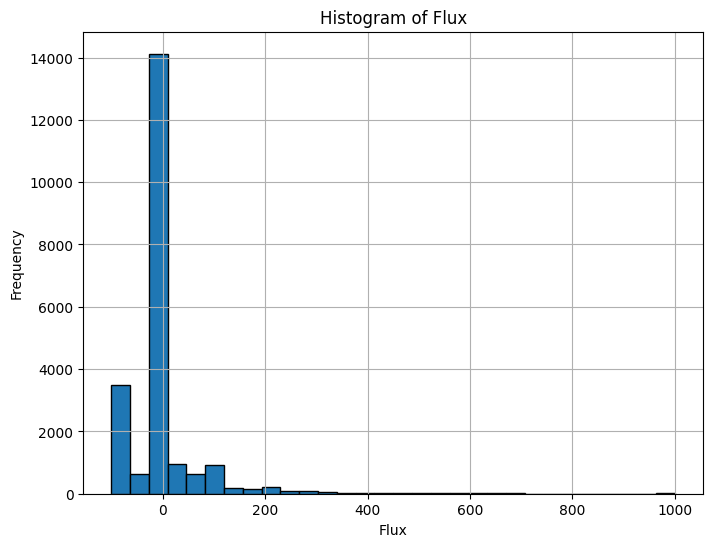

In [167]:
plt.figure(figsize=(8, 6))
plt.hist(exchanges["flux"], bins=30, edgecolor="black")
plt.title("Histogram of Flux")
plt.xlabel("Flux")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [130]:
group = exchanges.set_index("sample_id")["condition"]

In [ ]:
pl

# 🏫 Exercises

Up to now, we have mostly used MICOM's "high-level" API, which is designed for working with several samples in parallel. However, MICOM also allows you to work with single models. We will choose a single sample now for further analysis.

First, let's recall what samples we had. 

In [38]:
manifest.head()

sample_id sample_information               condition nikotin  \
sample_id                                                                     
s20011_0001  s20011_0001                 K1               Kontrolle      no   
s20011_0002  s20011_0002               PDM1  pankreopriver Diabetes     yes   
s20011_0003  s20011_0003              PDM13  pankreopriver Diabetes      no   
s20011_0004  s20011_0004                DM1  Diabetes mellitus Typ1      no   
s20011_0005  s20011_0005               DM13  Diabetes mellitus Typ1      no   

                sex age_group   AH                file  found_taxa  \
sample_id                                                            
s20011_0001  female    more50   no  s20011_0001.pickle         4.0   
s20011_0002  female    more50  yes  s20011_0002.pickle         2.0   
s20011_0003    male    more50  yes  s20011_0003.pickle         9.0   
s20011_0004  female    more50  yes  s20011_0004.pickle         4.0   
s20011_0005  female    less50   no  s20011_0005.pickle         4.0   

             total_taxa  found_fraction  found_abundance_fraction  
sample_id                                                          
s20011_0001         6.0        0.666667                  0.705725  
s20011_0002         3.0        0.666667                  0.690013  
s20011_0003         9.0        1.000000                  0.774552  
s20011_0004         5.0        0.800000                  0.665352  
s20011_0005         6.0        0.666667                  0.318763

Let's look further into the surprising *C. diff.* individual that looked very similar to the healthy subjects. We will apply the same diet as before.

This is a MICOM community object. MICOM community models are full [COBRApy](https://opencobra.github.io/cobrapy/) models (with sprinkles on top) and there is a whole bunch of stuff we could do with it.

## Microbe-microbe interactions

Let's dive a bit more into competition and cooperation between taxa. We can start by simulating taxa knockouts using `com.knockout_taxa`. For that we will remove each of the taxa from the model (one-at-a-time) and see how that affects the growth rates of all other taxa. If other taxa grow faster after the knockout, they were competing with the knocked-out taxon. However, if they grow slower, they were cooperating with the knocked-out taxon. 

See the docs for more info: https://micom-dev.github.io/micom/taxa_knockouts.html.

Bonus points if you can visualize your results. How would you deal with vastly different scales of growth rates between taxa?

> Oh geez. I once saw somebody plot a heatmap with Seaborn using a Pandas DataFrame. I wish I could remember where that was... 🤔


In [ ]:
# Your code here

## The flux capacitator

Here is how you would run the cooperative tradeoff for a single model. We can follow that up with pFBA to get all fluxes in the system.

In [41]:
sol = com.cooperative_tradeoff(fraction=0.5, fluxes=True, pfba=True)
sol

<CommunitySolution 0.188 at 0x14e5055444d0>

The returned solution contains all fluxes in `sol.fluxes`. An `NaN` entry denotes that this reaction is not present in the organism.

In [ ]:
sol.fluxes.head()

The acetate export reaction has the name `EX_ac(e)`. Identify the primary acetate producer in the system. Don't forget about the accuracy of 10<sup>-3</sup>.

In [ ]:
# Your code here

Look up at least one other reaction at https://www.vmh.life/#microbes/reactions, and get it's predicted fluxes. Does the reaction take place? If yes in which organism? Can you identify the most active fluxes in the community?

In [ ]:
# Your code here

# 🔵 Addendum


## Choosing a tradeoff value

Even if you don't have growth rates available you can still use your data to choose a decent tradeoff value. This can be done by choosing the largest tradeoff value that still allows growth for the majority of the taxa that you observed in the sample (if they are present at an appreciable abundance, they should be able to grow). This can be done with the `tradeoff` workflow in MICOM that will run cooperative tradeoff with varying tradeoff values, which can be visualized with the `plot_tradeoff` function.

In [28]:
import micom
from micom.workflows import tradeoff

tradeoff_results = tradeoff(manifest, "models", medium, threads=2)
tradeoff_results.to_csv("tradeoff.csv", index=False)

plot_tradeoff(tradeoff_results, tolerance=1e-4)

Output()

/home/kvalem/.local/lib/python3.11/site-packages/micom/viz/tradeoff.py:44: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


After opeing `tradeoff_[DATE].html` you will see that, for our example here, all tradeoff values work great. This is because we modeled very few taxa, which keeps the compettion down. If you would allow for fewer abundant taxa in the models, this would change drastically. For instance, here is an example from a colorectal cancer data set:

[![tradeoff example](https://micom-dev.github.io/micom/_images/tradeoff.png)](https://micom-dev.github.io/micom/_static/tradeoff.html)

You can see how not using the cooperative tradeoff would give you nonsense results where only 10% of all observed taxa grew. A tradeoff value of 0.6-0.8 would probably be a good choice for this particular data set.

In [ ]:
import numpy as np
import pandas as pd
from micom.measures import production_rates
from micom.viz import plot_association

prod = production_rates(results)
propionate = prod.loc[prod.metabolite == "ppa[e]", "flux"]
propionate.index = prod.sample_id.unique()
high_propionate = propionate > np.median(propionate)

pl = plot_association(
    results,
    phenotype=high_propionate,
    variable_type="binary",
    filename="association.html",
    fdr_threshold=0.5,
)

In [2]:
import pandas as pd

In [9]:
exchange_fluxes = pd.read_csv("./tmp_results/exchange_fluxes.csv")

In [10]:
exchange_fluxes

metabolite    sample_id      flux             description
0          ser_L_m  s20011_0028  0.000001                L-serine
1            csn_m  s20011_0028  0.000001                cytosine
2           dgsn_m  s20011_0028  0.082377          Deoxyguanosine
3          phe_L_m  s20011_0028  0.000001         L-phenylalanine
4             pi_m  s20011_0028  0.000001       hydrogenphosphate
...            ...          ...       ...                     ...
4699        dcyt_m  s20011_0044  0.100000           Deoxycytidine
4700  metsox_S_L_m  s20011_0044  0.100000  L-Methionine Sulfoxide
4701        cytd_m  s20011_0044  0.100000                Cytidine
4702      glyc3p_m  s20011_0044  0.000001    Glycerol 3-phosphate
4703       tyr_L_m  s20011_0044  0.007521              L-tyrosine

[4704 rows x 4 columns]

/tmp/ipykernel_1956130/2309037985.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['flux'] = pd.to_numeric(filtered_df['flux'], errors='coerce')
/tmp/ipykernel_1956130/2309037985.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['abundance'] = pd.to_numeric(filtered_df['abundance'], errors='coerce')


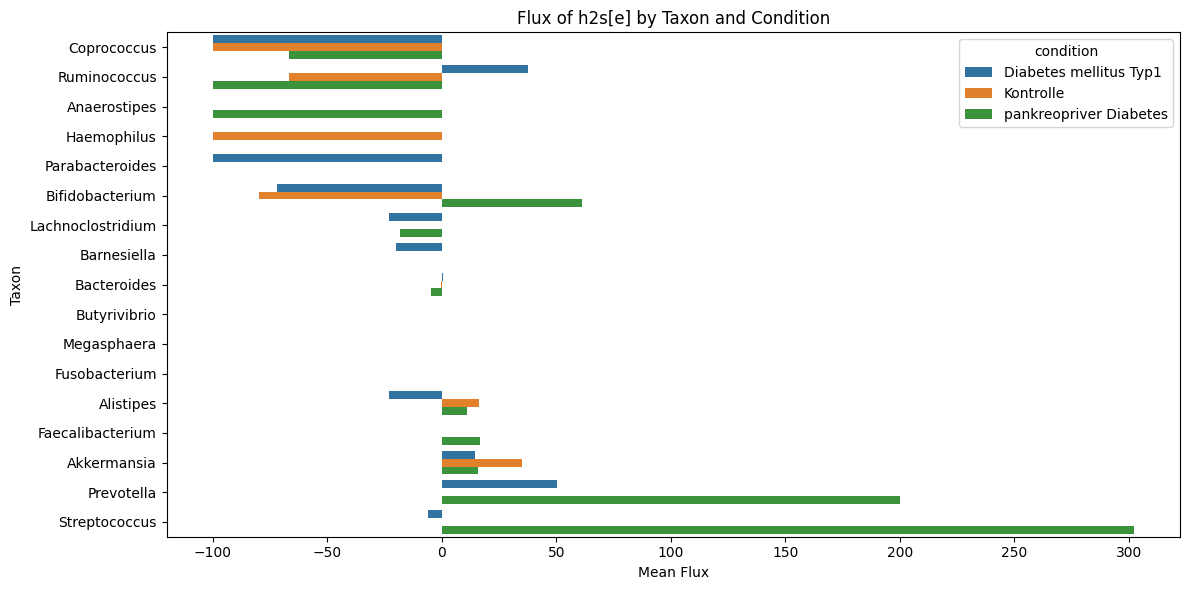

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure numeric types
filtered_df['flux'] = pd.to_numeric(filtered_df['flux'], errors='coerce')
filtered_df['abundance'] = pd.to_numeric(filtered_df['abundance'], errors='coerce')

# Focus on just h2s[e]
h2s_df = filtered_df[filtered_df['metabolite'] == 'h2s[e]'].copy()

# Group by taxon and condition
barplot_data = (
    h2s_df
    .groupby(['taxon', 'condition'])['flux']
    .mean()
    .reset_index()
)

# Optional: sort taxa by total flux for nice y-axis order
taxon_order = (
    barplot_data.groupby('taxon')['flux']
    .sum()
    .sort_values()
    .index
)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=barplot_data,
    y='taxon',
    x='flux',
    hue='condition',
    order=taxon_order
)
plt.title("Flux of h2s[e] by Taxon and Condition")
plt.xlabel("Mean Flux")
plt.ylabel("Taxon")
plt.tight_layout()
plt.show()


In [ ]:
import itertools

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind

# Your list of target metabolites
metabolites_of_interest = significant_metabolites

# Make sure your DataFrame is loaded and contains: "description", "condition", "flux"
# Example: exchange_fluxes = pd.read_csv("your_file.csv")

# Extract unique conditions and define all pairwise comparisons
conditions = exchanges["condition"].unique().tolist()
comparisons = list(itertools.combinations(conditions, 2))

# Grid layout
n_cols = 3
n_rows = (len(metabolites_of_interest) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
axes = axes.flatten()

# Loop through metabolites and plot
for i, metabolite in enumerate(metabolites_of_interest):
    ax = axes[i]
    df = exchanges[exchanges["description"] == metabolite]

    if df.empty:
        ax.set_visible(False)
        continue

    # Boxplot
    sns.boxplot(data=df, x="condition", y="flux", ax=ax, showcaps=True,
                boxprops={'facecolor': 'None'}, showfliers=False,
                whiskerprops={'linewidth': 2}, medianprops={'color': 'black'})
    # Swarmplot
    sns.swarmplot(data=df, x="condition", y="flux", ax=ax, color=".25", size=4)

    # Add p-values
    y_max = df["flux"].max()
    y_start = y_max * 1.05
    h = y_max * 0.05

    for j, (cond1, cond2) in enumerate(comparisons):
        group1 = df[df["condition"] == cond1]["flux"]
        group2 = df[df["condition"] == cond2]["flux"]

        if group1.empty or group2.empty:
            continue

        stat, pval = ttest_ind(group1, group2)
        x1 = conditions.index(cond1)
        x2 = conditions.index(cond2)
        y = y_start + j * h * 1.5
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.2, c='black')
        ax.text((x1 + x2) / 2, y + h * 1.05, f"p = {pval:.3e}", ha='center', va='bottom', fontsize=8)

    ax.set_title(metabolite, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("Flux", fontsize=9)
    ax.tick_params(axis='x', rotation=45)

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()
# Save to PDF
pdf_path = "metabolite_flux_comparison_plots.pdf"
#with PdfPages(pdf_path) as pdf:
pdf.savefig(fig)#

print(f"PDF saved to: {pdf_path}")

/home/kvalem/.local/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 96.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/kvalem/.local/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 97.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/kvalem/.local/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 98.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/kvalem/.local/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [30]:
from matplotlib.backends.backend_pdf import PdfPages

In [78]:
exchange_fluxes_female = exchange_fluxes[exchange_fluxes["AH"] == "yes"]

In [79]:
heatmap_data = exchange_fluxes_female.pivot_table(
    index="description",  # rows = metabolites
    columns="sample_information",  # columns = sample types
    values="flux",  # values = flux values
    aggfunc="mean",  # if duplicates exist, average them
)

/tmp/ipykernel_1914631/448702739.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


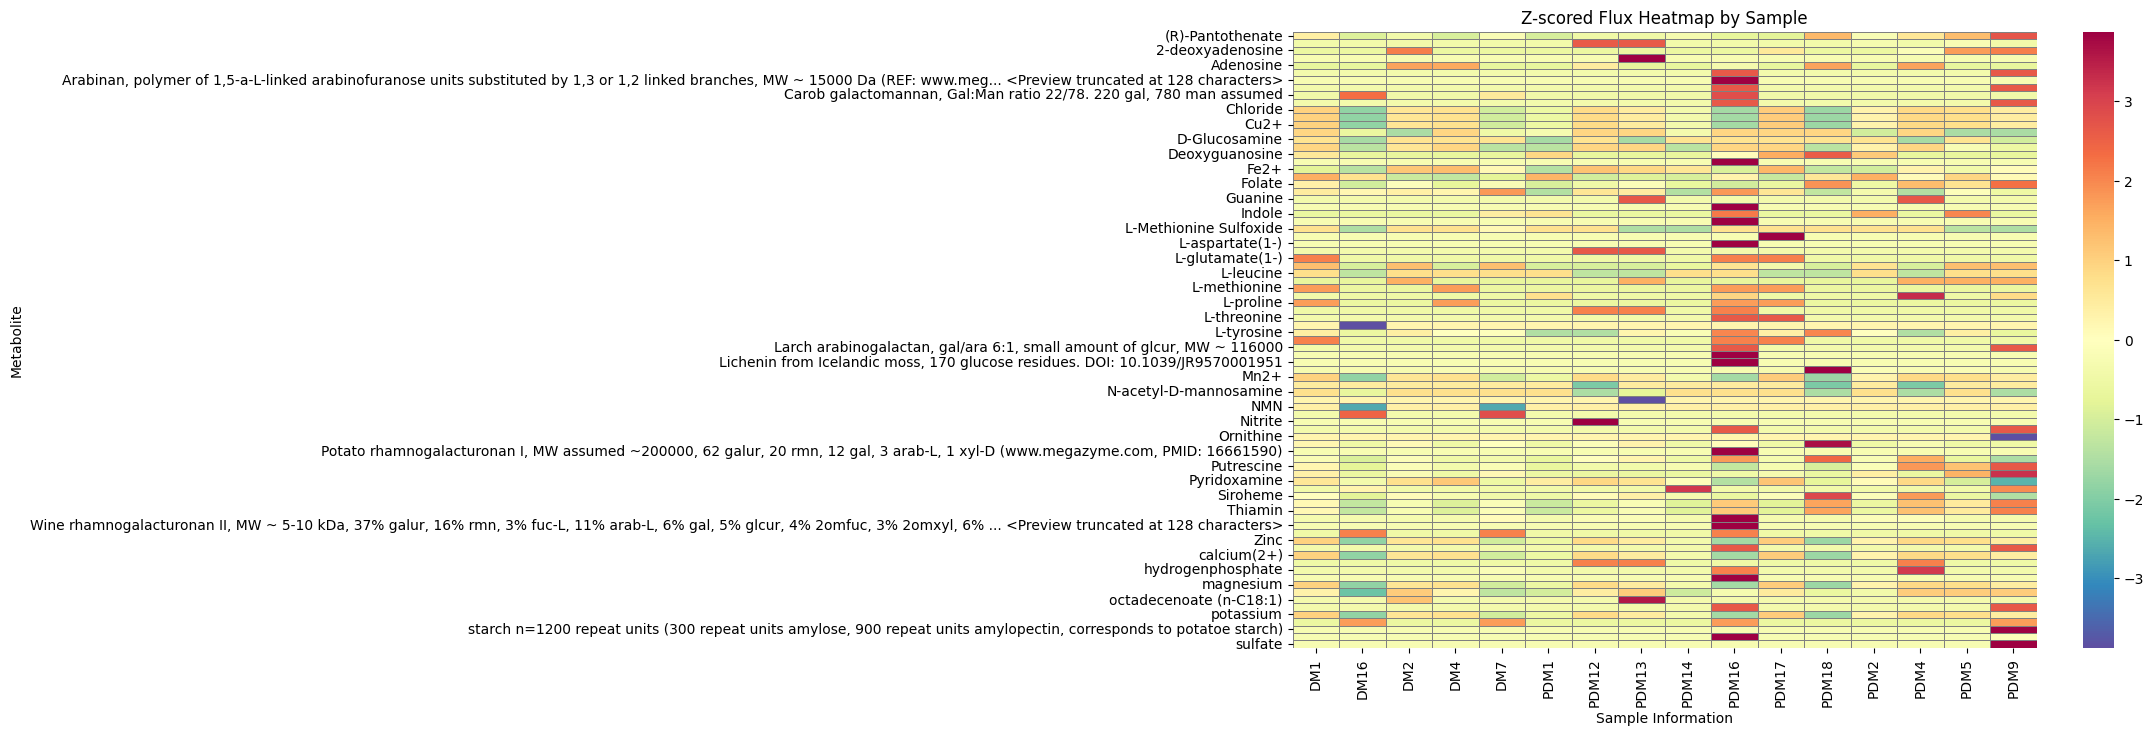

In [80]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import zscore

# Step 1: Pivot to get flux matrix
flux_matrix = exchange_fluxes_female.pivot_table(
    index="description", columns="sample_information", values="flux", aggfunc="mean"
)

# Step 2: Compute row-wise (metabolite-wise) z-score
flux_z = flux_matrix.apply(zscore, axis=1, nan_policy="omit")
flux_z = flux_z.dropna(how="all")

# Step 3: Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(flux_z, cmap="Spectral_r", center=0, linewidths=0.5, linecolor="gray")
plt.title("Z-scored Flux Heatmap by Sample")
plt.xlabel("Sample Information")
plt.ylabel("Metabolite")
plt.tight_layout()
plt.show()

In [81]:
growth_rates = pd.read_csv("growth_rates.csv")

In [83]:
growth_rates = pd.merge(growth_rates, metadata, on="sample_id")
growth_rates

taxon    sample_id  abundance  growth_rate sample_information  \
0         Bacteroides  s20011_0002   0.929622     0.200480               PDM1   
1             Blautia  s20011_0002   0.070378     0.019651               PDM1   
2         Akkermansia  s20011_0001   0.099298     0.046649                 K1   
3         Bacteroides  s20011_0001   0.641559     0.259024                 K1   
4             Blautia  s20011_0001   0.193235     0.079613                 K1   
..                ...          ...        ...          ...                ...   
249         Alistipes  s20011_0049   0.183574     0.185159               DM12   
250       Bacteroides  s20011_0049   0.339431     0.310949               DM12   
251       Barnesiella  s20011_0049   0.044797     0.045166               DM12   
252   Bifidobacterium  s20011_0049   0.041157     0.041381               DM12   
253  Faecalibacterium  s20011_0049   0.064442     0.055484               DM12   

                  condition nikotin     sex age_group   AH  
0    pankreopriver Diabetes     yes  female    more50  yes  
1    pankreopriver Diabetes     yes  female    more50  yes  
2                 Kontrolle      no  female    more50   no  
3                 Kontrolle      no  female    more50   no  
4                 Kontrolle      no  female    more50   no  
..                      ...     ...     ...       ...  ...  
249  Diabetes mellitus Typ1      no    male    less50   no  
250  Diabetes mellitus Typ1      no    male    less50   no  
251  Diabetes mellitus Typ1      no    male    less50   no  
252  Diabetes mellitus Typ1      no    male    less50   no  
253  Diabetes mellitus Typ1      no    male    less50   no  

[254 rows x 10 columns]

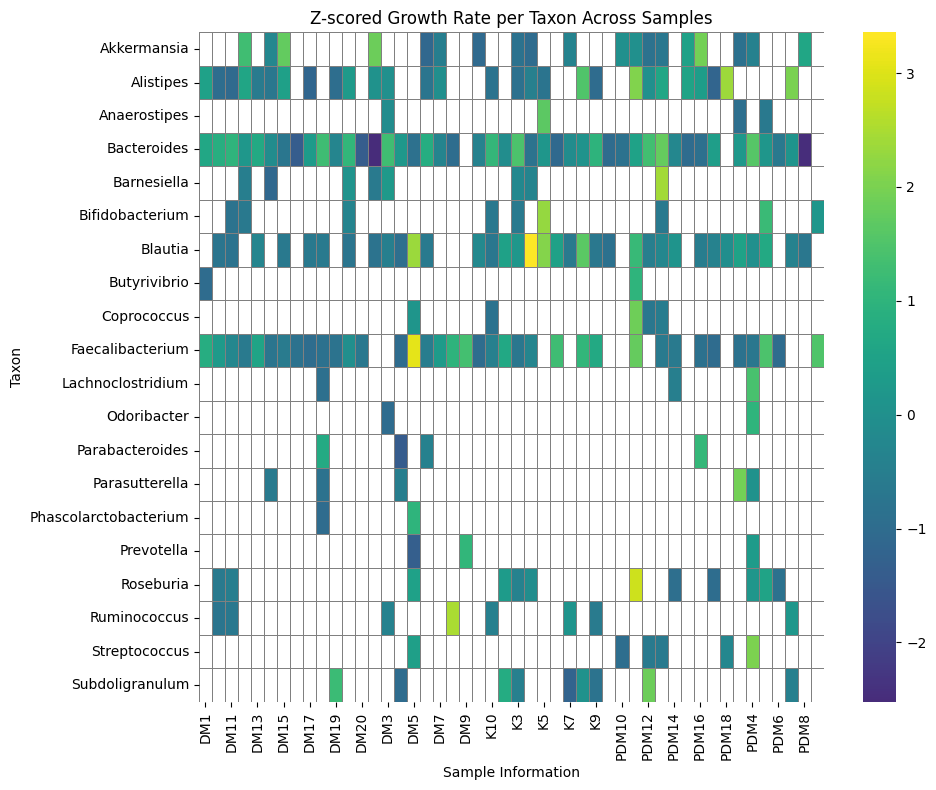

In [98]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import zscore

# Step 1: Pivot to get growth_rate matrix
growth_matrix = growth_rates.pivot_table(
    index="taxon",
    columns="sample_information",
    values="growth_rate",
    aggfunc="mean",  # average if duplicate entries
)

# Step 2: Z-score by taxon (row-wise)
growth_z = growth_matrix.apply(zscore, axis=1, nan_policy="omit")

# Step 3: Drop rows with all NaNs
growth_z = growth_z.dropna(how="all")

# Step 4: Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    growth_z,
    cmap="viridis",  # diverging colormap
    center=0,
    linewidths=0.5,
    linecolor="gray",
)
plt.title("Z-scored Growth Rate per Taxon Across Samples")
plt.xlabel("Sample Information")
plt.ylabel("Taxon")
plt.tight_layout()
plt.show()

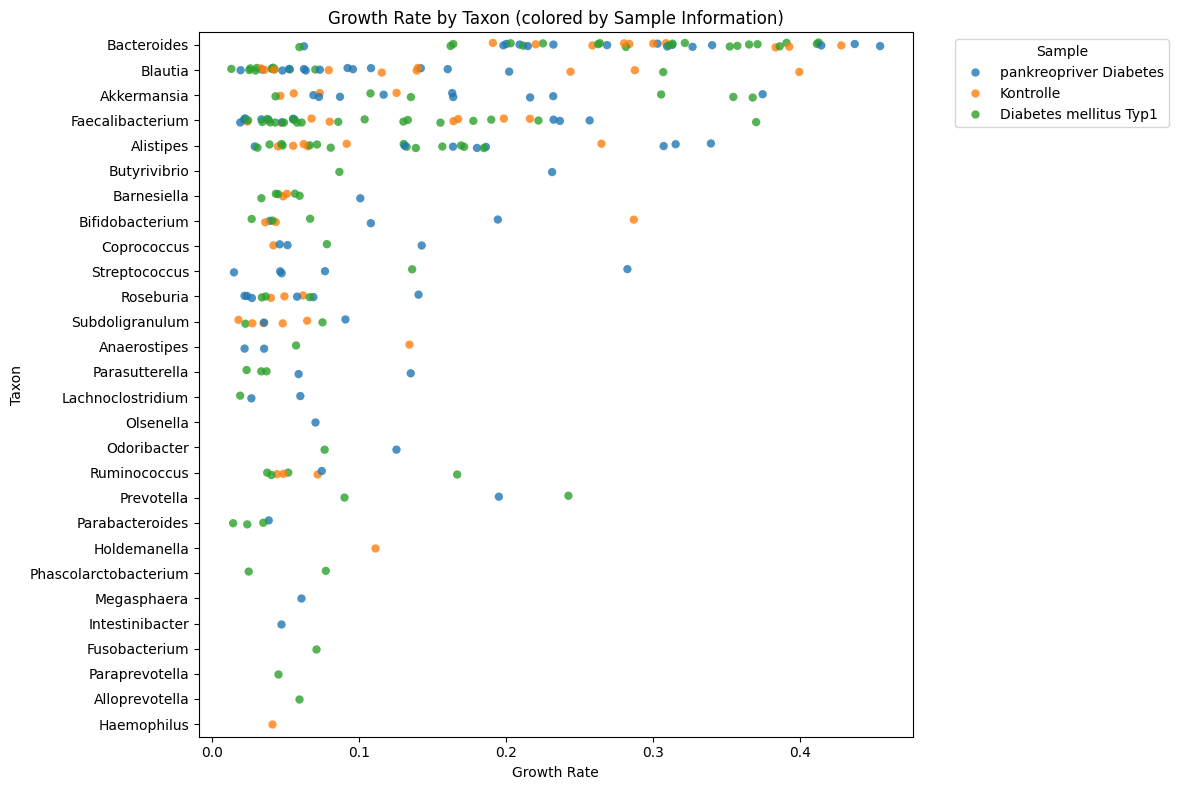

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.stripplot(
    data=growth_rates,
    x="growth_rate",
    y="taxon",
    hue="condition",
    jitter=True,
    dodge=False,
    size=6,
    alpha=0.8,
)

plt.title("Growth Rate by Taxon (colored by Sample Information)")
plt.xlabel("Growth Rate")
plt.ylabel("Taxon")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Sample")
plt.tight_layout()
plt.show()

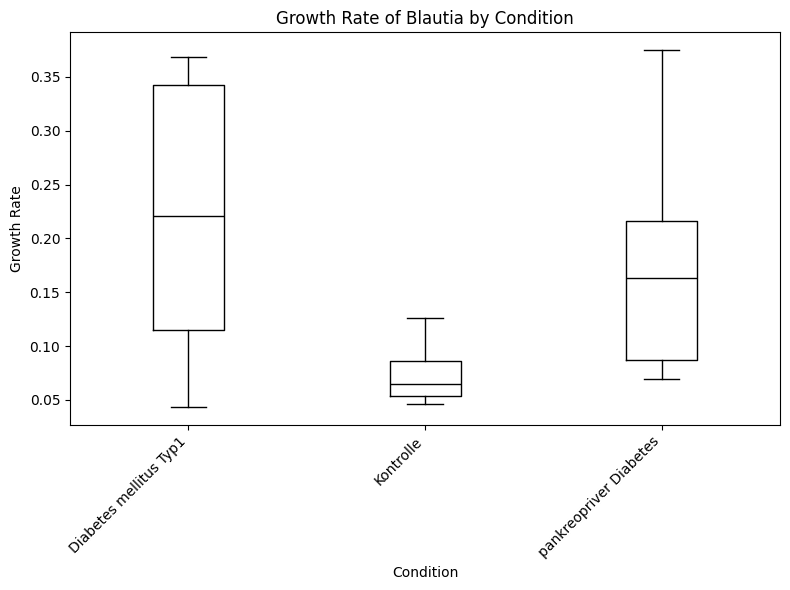

In [112]:
import matplotlib.pyplot as plt

# Step 1: Filter to Blautia only
blautia_df = growth_rates[growth_rates["taxon"] == "Akkermansia"]

# Step 2: Group growth rates by condition
grouped = blautia_df.groupby("condition")["growth_rate"].apply(list)

# Step 3: Create boxplot
fig, ax = plt.subplots(figsize=(8, 6))
box = ax.boxplot(
    grouped.values,
    patch_artist=False,  # to allow box coloring
    showfliers=True,  # optionally show outliers
    medianprops=dict(color="black"),
)

# Step 4: Set x-ticks and labels
ax.set_xticks(range(1, len(grouped) + 1))
ax.set_xticklabels(grouped.index, rotation=45, ha="right")

# Step 5: Add labels and title
ax.set_ylabel("Growth Rate")
ax.set_xlabel("Condition")
ax.set_title("Growth Rate of Blautia by Condition")

plt.tight_layout()
plt.show()

In [155]:
reduced = pd.read_csv("./tmp_results/reduced.csv")

In [156]:
reduced

sample_id             taxon     TSNE 1     TSNE 2
0    s20011_0001       Akkermansia -41.626290 -21.268959
1    s20011_0001       Bacteroides   7.162922  19.423496
2    s20011_0001           Blautia   4.558453 -67.140450
3    s20011_0001  Faecalibacterium -13.098630 -15.627763
4    s20011_0002       Bacteroides   7.093894  21.891940
..           ...               ...        ...        ...
249  s20011_0049         Alistipes  33.732330  22.897322
250  s20011_0049       Bacteroides  28.193733  40.809850
251  s20011_0049       Barnesiella  62.278200 -21.823647
252  s20011_0049   Bifidobacterium -41.554283  35.875870
253  s20011_0049  Faecalibacterium  -5.540465 -15.249521

[254 rows x 4 columns]

In [157]:
reduced = pd.merge(reduced, metadata, on="sample_id")
reduced

sample_id             taxon     TSNE 1     TSNE 2 sample_information  \
0    s20011_0001       Akkermansia -41.626290 -21.268959                 K1   
1    s20011_0001       Bacteroides   7.162922  19.423496                 K1   
2    s20011_0001           Blautia   4.558453 -67.140450                 K1   
3    s20011_0001  Faecalibacterium -13.098630 -15.627763                 K1   
4    s20011_0002       Bacteroides   7.093894  21.891940               PDM1   
..           ...               ...        ...        ...                ...   
249  s20011_0049         Alistipes  33.732330  22.897322               DM12   
250  s20011_0049       Bacteroides  28.193733  40.809850               DM12   
251  s20011_0049       Barnesiella  62.278200 -21.823647               DM12   
252  s20011_0049   Bifidobacterium -41.554283  35.875870               DM12   
253  s20011_0049  Faecalibacterium  -5.540465 -15.249521               DM12   

                  condition nikotin     sex age_group   AH  
0                 Kontrolle      no  female    more50   no  
1                 Kontrolle      no  female    more50   no  
2                 Kontrolle      no  female    more50   no  
3                 Kontrolle      no  female    more50   no  
4    pankreopriver Diabetes     yes  female    more50  yes  
..                      ...     ...     ...       ...  ...  
249  Diabetes mellitus Typ1      no    male    less50   no  
250  Diabetes mellitus Typ1      no    male    less50   no  
251  Diabetes mellitus Typ1      no    male    less50   no  
252  Diabetes mellitus Typ1      no    male    less50   no  
253  Diabetes mellitus Typ1      no    male    less50   no  

[254 rows x 10 columns]

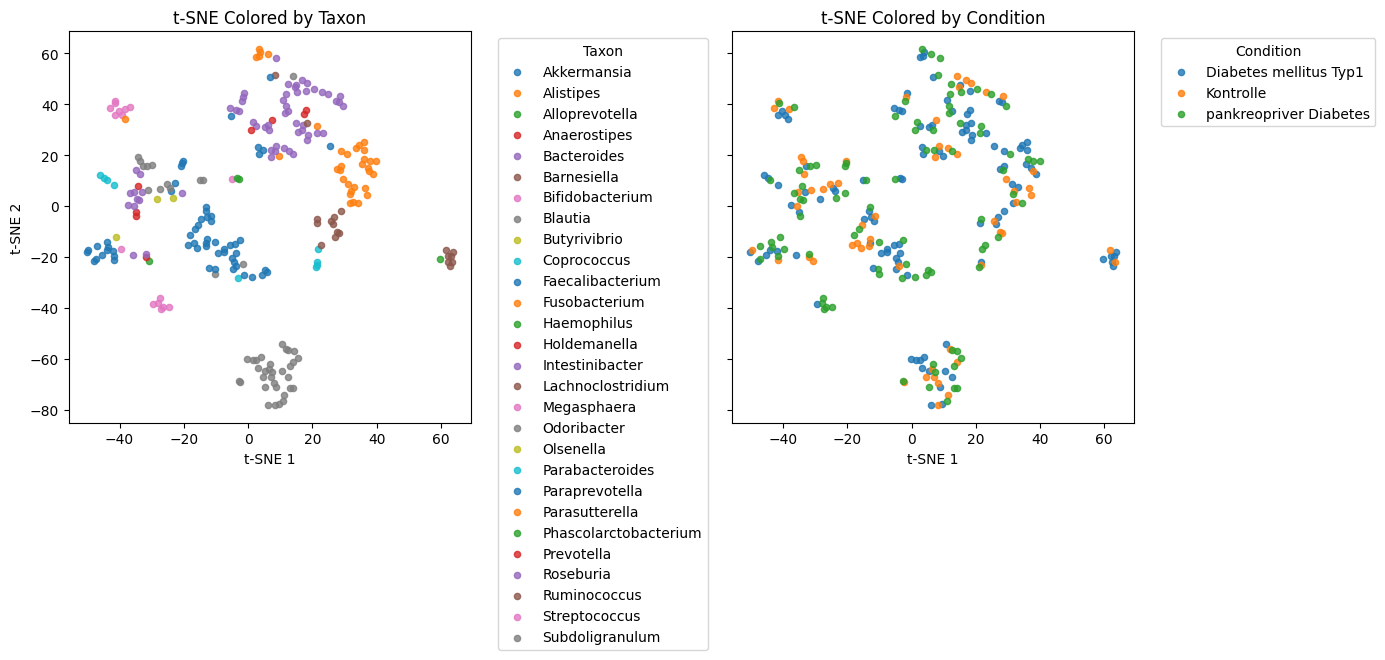

In [164]:
import matplotlib.pyplot as plt

# Step 1: Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Step 2: Plot colored by taxon
for taxon, group in reduced.groupby("taxon"):
    axes[0].scatter(group["TSNE 1"], group["TSNE 2"], label=taxon, alpha=0.8, s=20)
axes[0].set_title("t-SNE Colored by Taxon")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")
axes[0].legend(title="Taxon", bbox_to_anchor=(1.05, 1), loc="upper left")

# Step 3: Plot colored by condition
for cond, group in reduced.groupby("condition"):
    axes[1].scatter(group["TSNE 1"], group["TSNE 2"], label=cond, alpha=0.8, s=20)
axes[1].set_title("t-SNE Colored by Condition")
axes[1].set_xlabel("t-SNE 1")
axes[1].legend(title="Condition", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()